# Import Libraries

In [200]:
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests
from time import sleep

# Collect Data

Initial inspection

In [2]:
url = 'https://www.sports-reference.com/cbb/schools/duke/2022-gamelogs.html'

In [3]:
req = requests.get(url, 'lxml')
soup = BeautifulSoup(req.content)

Get the location of the columns we plan to scrape. Game number appears to be in a unique situation.

In [4]:
th = soup.find('table', {'id':'sgl-basic'}).find('thead').find_all('tr')[1].find_all('th')[0]
th.attrs

{'aria-label': 'G',
 'data-stat': 'game_season',
 'scope': 'col',
 'class': ['poptip', 'center']}

Find the names of all the columns in the table

In [5]:
cols = []
for th in soup.find('table', {'id':'sgl-basic'}).find('thead').find_all('tr')[1].find_all('th'):
    cols.append(th['data-stat'])
cols

['game_season',
 'date_game',
 'game_location',
 'opp_id',
 'game_result',
 'pts',
 'opp_pts',
 'fg',
 'fga',
 'fg_pct',
 'fg3',
 'fg3a',
 'fg3_pct',
 'ft',
 'fta',
 'ft_pct',
 'orb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'x',
 'opp_fg',
 'opp_fga',
 'opp_fg_pct',
 'opp_fg3',
 'opp_fg3a',
 'opp_fg3_pct',
 'opp_ft',
 'opp_fta',
 'opp_ft_pct',
 'opp_orb',
 'opp_trb',
 'opp_ast',
 'opp_stl',
 'opp_blk',
 'opp_tov',
 'opp_pf']

Schools data to collect

In [6]:
schools = ['duke', 'villanova', 'north-carolina', 'kansas']

Extract the values from the rows

In [7]:
all_games = pd.DataFrame()

for school in schools:

    url = f'https://www.sports-reference.com/cbb/schools/{school}/2022-gamelogs.html'
    req = requests.get(url, 'lxml')
    soup = BeautifulSoup(req.content)

    data_scrape = {}
    for tr in soup.find('table', {'id':'sgl-basic'}).find('tbody').find_all('tr'):
        if tr.find('th').get('data-stat') == 'game_season':
            new_game = tr.find('th').text                                           # game number
            data_scrape[new_game] = {}

            for td in tr.find_all('td'):                                            # iterate over columns
                if td.get('data-stat') in cols:                                     # collect if stat is in our stat list
                    c = td.get('data-stat')                                         # stat name
                    data_scrape[new_game][c] = td.text                              # stat value
                            
    games = pd.DataFrame(data_scrape).T                                             # conver to data frame

    if 'G' in games.index:                                                          # remove empty rows, if present
        games.drop(labels='G', axis=0, inplace=True)

    if 'x' in games.columns:
        games.drop(labels='x', axis=1, inplace=True)                                # remove empty column

    games['school'] = school
    games = games[['school'] + list(games.columns[:-1])]

    sleep(5)                                                                        # be kind

    all_games = pd.concat([all_games, games], ignore_index=True)
       

# Data Cleaning

Add in school conference

In [8]:
all_games['conf'] = all_games['school'].map({'duke': 'acc', 'north-carolina': 'acc', 'kansas':'big12', 'villanova': 'bigeast'})

In [9]:
all_games = all_games[['school', 'conf'] + list(all_games.columns[1:-1])]

Time to start cleaning up the columns. Data types have all been imported as strings with no missing values

In [10]:
all_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   school         150 non-null    object
 1   conf           150 non-null    object
 2   date_game      150 non-null    object
 3   game_location  150 non-null    object
 4   opp_id         150 non-null    object
 5   game_result    150 non-null    object
 6   pts            150 non-null    object
 7   opp_pts        150 non-null    object
 8   fg             150 non-null    object
 9   fga            150 non-null    object
 10  fg_pct         150 non-null    object
 11  fg3            150 non-null    object
 12  fg3a           150 non-null    object
 13  fg3_pct        150 non-null    object
 14  ft             150 non-null    object
 15  fta            150 non-null    object
 16  ft_pct         150 non-null    object
 17  orb            150 non-null    object
 18  trb            150 non-null   

Convert date to datetime

In [11]:
all_games['date_game'] = pd.to_datetime(all_games['date_game'])
all_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   school         150 non-null    object        
 1   conf           150 non-null    object        
 2   date_game      150 non-null    datetime64[ns]
 3   game_location  150 non-null    object        
 4   opp_id         150 non-null    object        
 5   game_result    150 non-null    object        
 6   pts            150 non-null    object        
 7   opp_pts        150 non-null    object        
 8   fg             150 non-null    object        
 9   fga            150 non-null    object        
 10  fg_pct         150 non-null    object        
 11  fg3            150 non-null    object        
 12  fg3a           150 non-null    object        
 13  fg3_pct        150 non-null    object        
 14  ft             150 non-null    object        
 15  fta            150 non-

Map location to home/away/neutral court

In [12]:
all_games['game_location'].value_counts()

     65
@    45
N    40
Name: game_location, dtype: int64

In [13]:
all_games['game_location'] = all_games['game_location'].map({'': 'home', '@': 'away', 'N': 'neutral'})
all_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   school         150 non-null    object        
 1   conf           150 non-null    object        
 2   date_game      150 non-null    datetime64[ns]
 3   game_location  150 non-null    object        
 4   opp_id         150 non-null    object        
 5   game_result    150 non-null    object        
 6   pts            150 non-null    object        
 7   opp_pts        150 non-null    object        
 8   fg             150 non-null    object        
 9   fga            150 non-null    object        
 10  fg_pct         150 non-null    object        
 11  fg3            150 non-null    object        
 12  fg3a           150 non-null    object        
 13  fg3_pct        150 non-null    object        
 14  ft             150 non-null    object        
 15  fta            150 non-

Clean win/loss column

In [14]:
all_games['game_result'].value_counts()

W           117
L            26
W (1 OT)      4
L (1 OT)      2
W (2 OT)      1
Name: game_result, dtype: int64

In [15]:
all_games['game_result'] = all_games['game_result'].map(lambda x: x[0])
all_games['game_result'] = all_games['game_result'].map({'W': 1, 'L': 0})

Convert numeric columns into a number type

In [16]:
all_games.loc[:,'pts':'opp_pf'] = all_games.loc[:,'pts':].astype(np.number)

Data set is very small, so floats are ok in this situation.

In [17]:
all_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   school         150 non-null    object        
 1   conf           150 non-null    object        
 2   date_game      150 non-null    datetime64[ns]
 3   game_location  150 non-null    object        
 4   opp_id         150 non-null    object        
 5   game_result    150 non-null    int64         
 6   pts            150 non-null    float64       
 7   opp_pts        150 non-null    float64       
 8   fg             150 non-null    float64       
 9   fga            150 non-null    float64       
 10  fg_pct         150 non-null    float64       
 11  fg3            150 non-null    float64       
 12  fg3a           150 non-null    float64       
 13  fg3_pct        150 non-null    float64       
 14  ft             150 non-null    float64       
 15  fta            150 non-

Great. Data is looking fairly clean. Time to start analyzing it.

# Exploratory Data Analysis

In [18]:
data = all_games.copy(deep=True)

In [19]:
cols_small = ['school',
    'game_result', 'pts', 'opp_pts', 'fg_pct', 'fg3_pct', 'ft_pct', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf'
]

In [20]:
stat_cols = list(data.select_dtypes(include=np.number).columns)

In [21]:
data[cols_small]

,school,game_result,pts,opp_pts,fg_pct,fg3_pct,ft_pct,trb,ast,stl,blk,tov,pf
0,duke,1,79.0,71.0,0.517,0.083,0.696,31.0,8.0,9.0,5.0,9.0,15.0
1,duke,1,82.0,56.0,0.437,0.310,0.846,39.0,21.0,14.0,3.0,11.0,12.0
2,duke,1,67.0,56.0,0.500,0.391,0.727,30.0,16.0,6.0,4.0,10.0,12.0
3,duke,1,92.0,52.0,0.571,0.455,0.714,41.0,24.0,8.0,7.0,11.0,12.0
4,duke,1,88.0,55.0,0.456,0.400,0.571,48.0,19.0,11.0,5.0,8.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,kansas,1,74.0,65.0,0.431,0.227,0.781,33.0,12.0,8.0,2.0,13.0,16.0
146,kansas,1,83.0,56.0,0.500,0.478,0.444,39.0,20.0,8.0,1.0,15.0,21.0
147,kansas,1,79.0,72.0,0.409,0.375,0.950,46.0,14.0,5.0,7.0,7.0,21.0
148,kansas,1,66.0,61.0,0.393,0.133,0.714,36.0,7.0,3.0,11.0,10.0,15.0


## Correlations

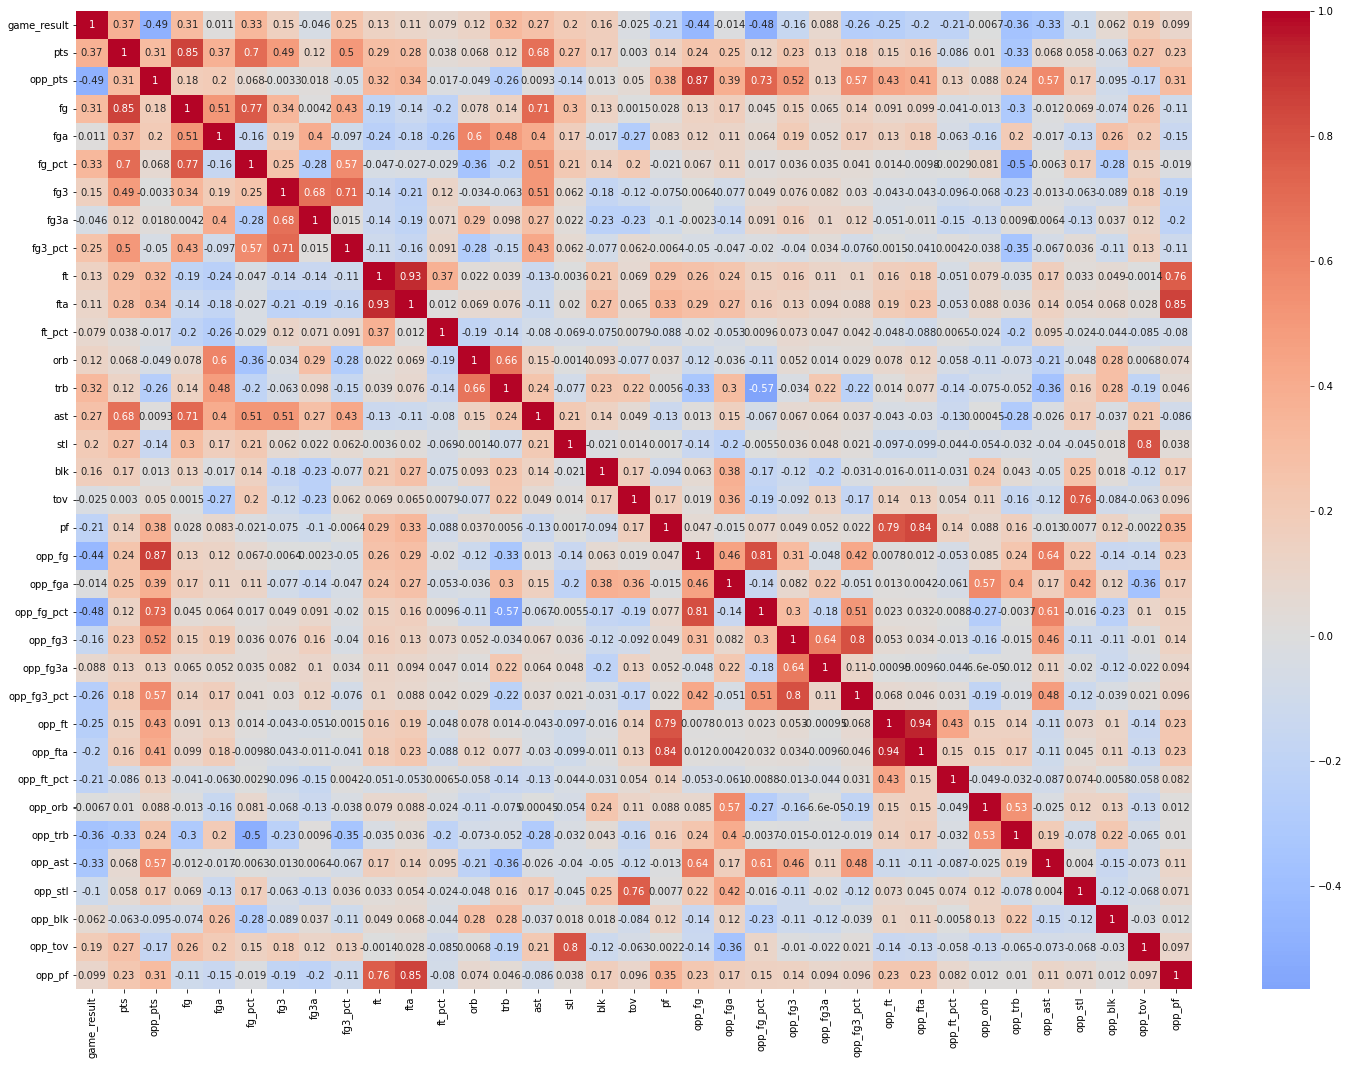

In [22]:
plt.figure(figsize=(25, 18))
corrs = sns.heatmap(data=data.corr(), cmap='coolwarm', annot=True, center=0)

Will want to examine the following features more closely based on the corr matrix:\
pts, opp_pts, fg, fg_pct, fg3_pct, trb, ast, stl, opp_fg, opp_fg_pct, opp_fg3_pct, opp_ft, opp_trb, opp_ast

In [23]:
cols_corrs = ['school', 'game_result', 'pts', 'opp_pts', 'fg', 'fg_pct', 'fg3_pct',
              'trb', 'ast', 'stl', 'opp_fg', 'opp_fg_pct', 'opp_fg3_pct', 'opp_ft', 
              'opp_trb', 'opp_ast']

Setting up the graphs. The initial step is to look at the distributions of data at a macro perspective. Game result is the most important factor, so I have decided to highlight it at the macro level with color. Hopefully the eye will be drawn to certain plots. Taking a look at the shape of the distributions will be vital for deciding what type of model could be ideal for making predictions. Many regression models operate under the assumption of a linear relationship (and independ features, but that is quite rare in the real world). 

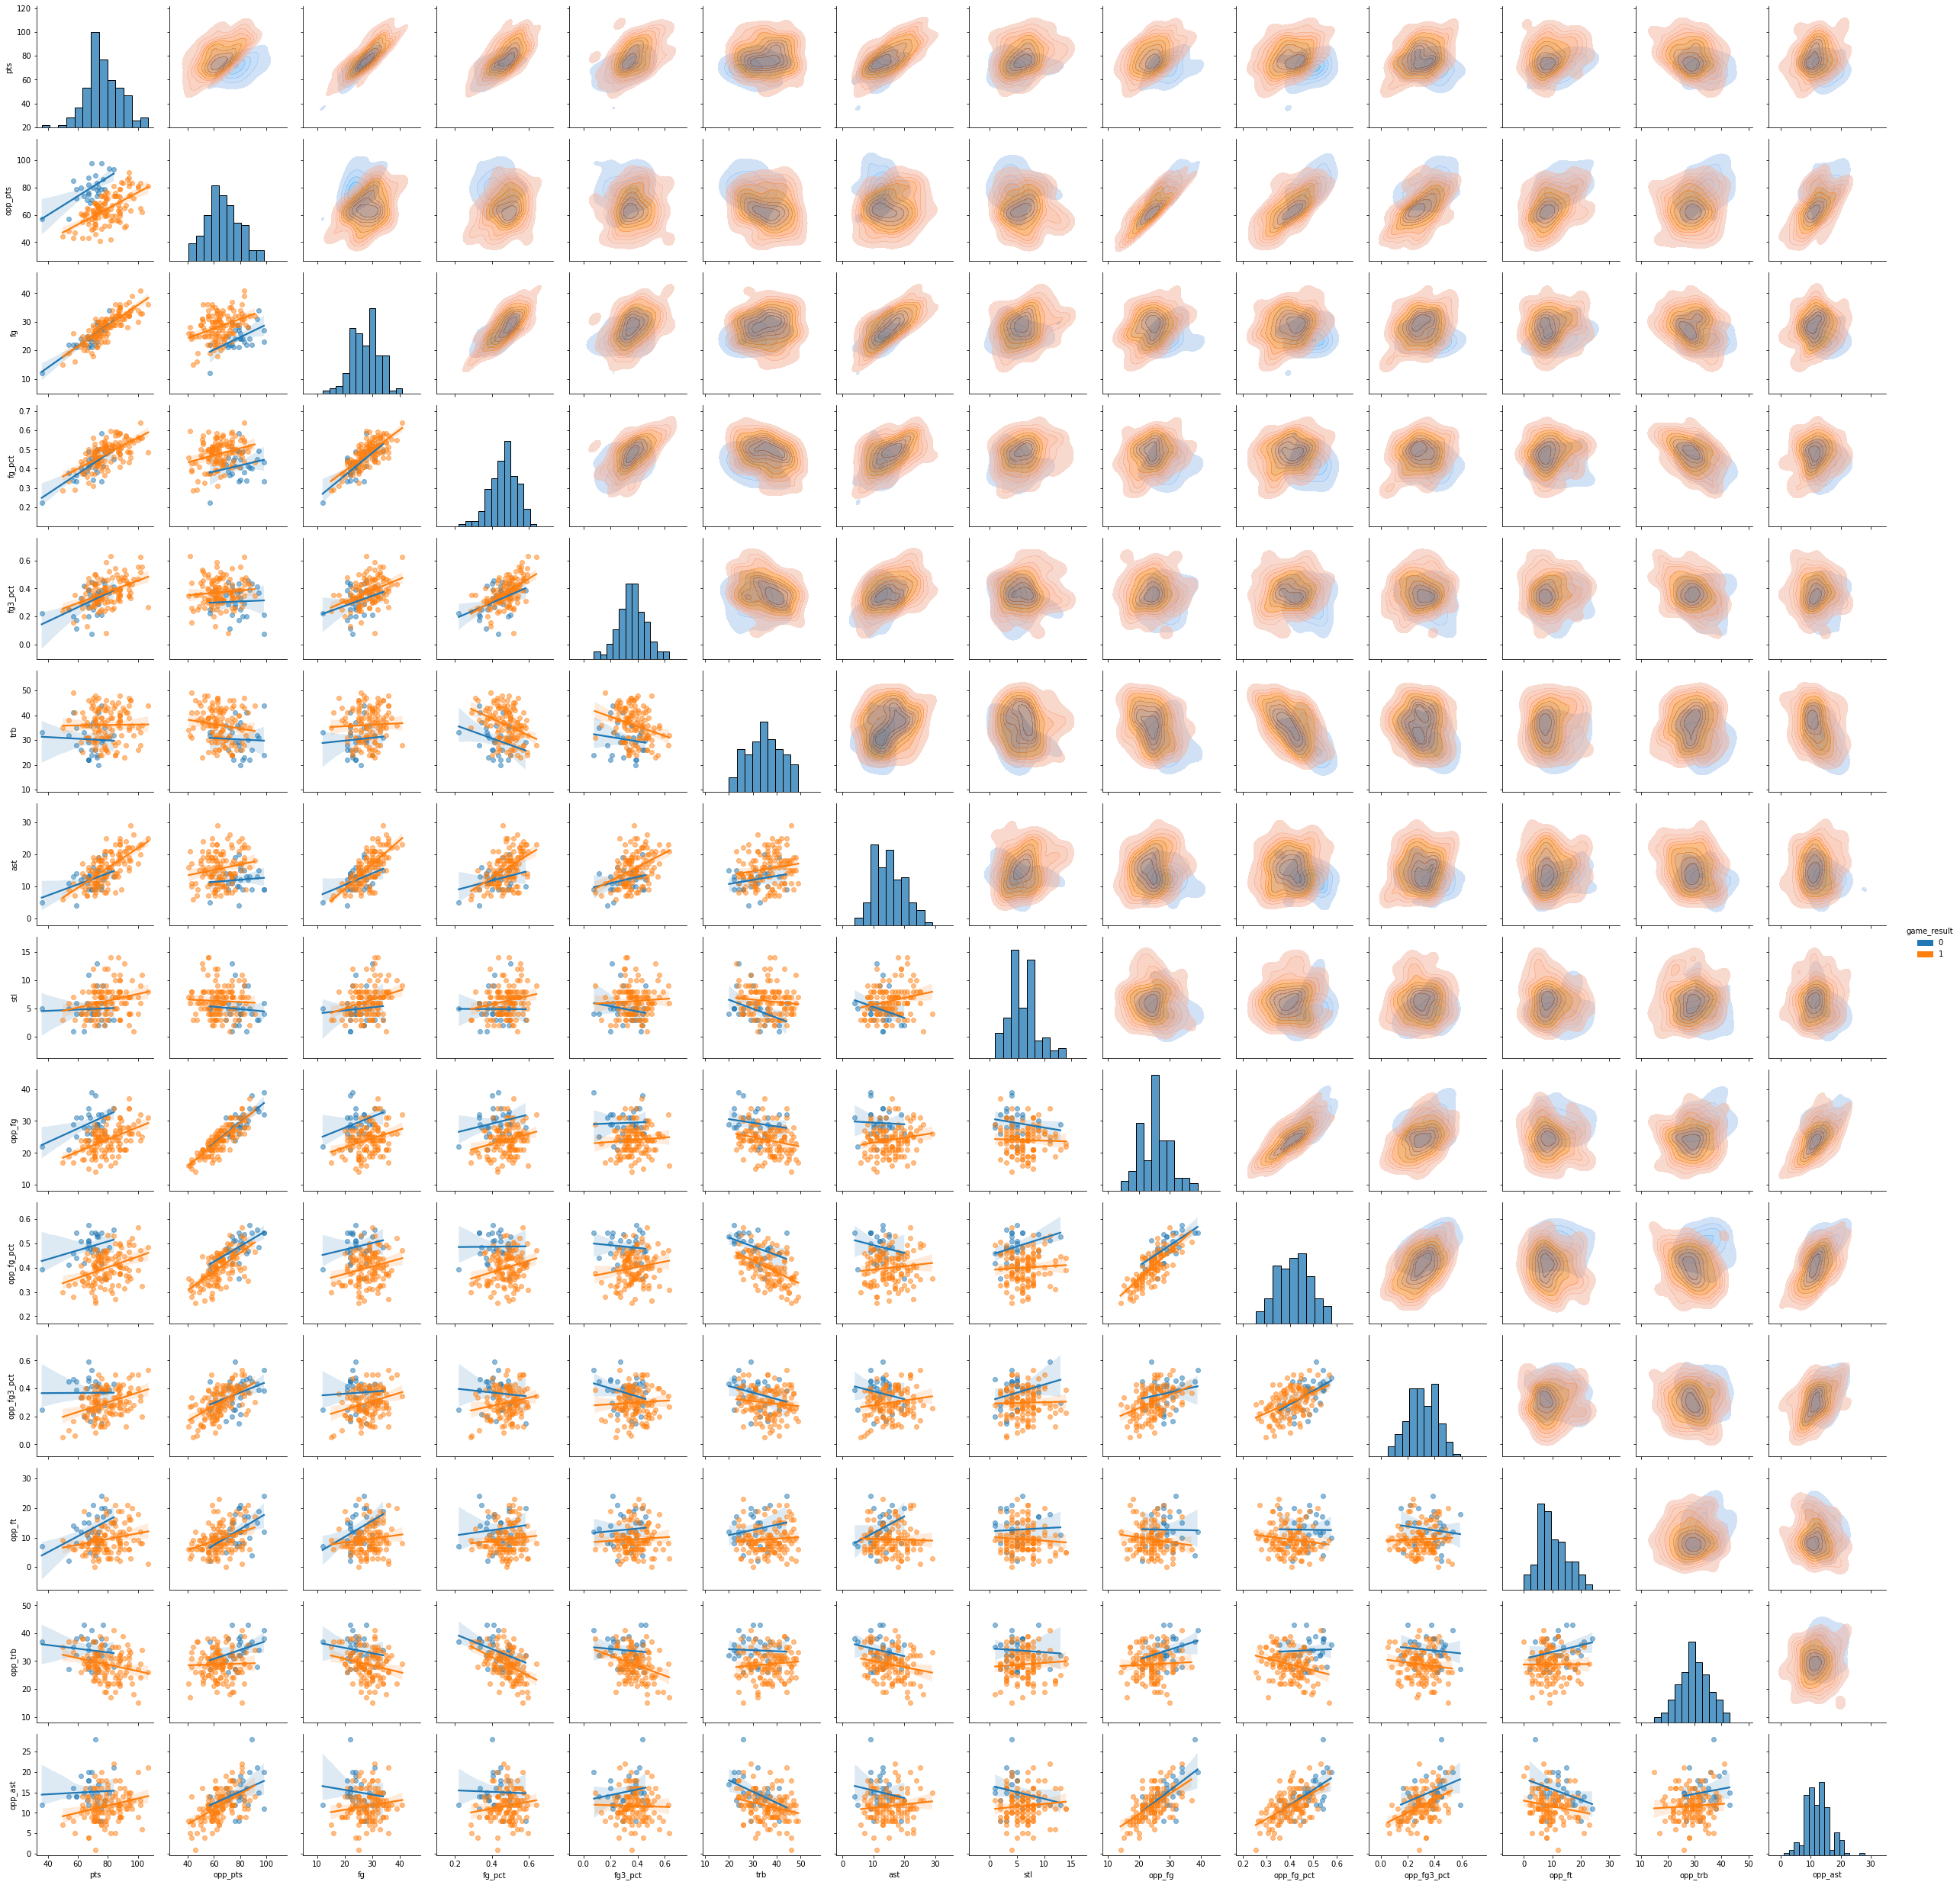

In [24]:
g = sns.PairGrid(data=data[cols_corrs], hue='game_result')
g.map_diag(sns.histplot, hue=None)
g.map_lower(sns.regplot, scatter_kws={'alpha':0.5})
g.map_upper(sns.kdeplot, fill=True, alpha=.5)
g.add_legend()
sns.despine()
plt.show()

A lot to digest in this pair grid. The goal is to narrow in on some correlations that are going to be worth exploring in more detail. I always start by looking at the distributions. In a perfect world, they will all be mostly normal-ish (symmetric). None of the histograms have overly heavy tails (a skew toward the left or right), so our data should be reasonably easy to find connections. \
Next, I like to move to the density plots on the top right side of the chart. I'm mostly looking for oblong shapes with either strong positive or negative correlations. I will list a few that stand out at a glance. \
* ast -- pts
* opp_ast -- opp_pts
* fg -- ast
* opp_fg -- opp_ast

I'm omitting obvious correlations like pts and fg_pct.

Next I will look for connections where the orange (wins) and blue (losses) densities are separated or stacked in a clear way.
* pts -- trb
* opp_pts -- opp_trb
* opp_pts -- stl
* opp_pts -- trb
* trb -- opp_trb
* ast -- stl
* opp_trb -- opp_fg_pct

Last I will look over the scatter/trend lines in the bottom left section of the chart. Orange and blue lines with different slops are of interest. Will skip if they appear in the above section.
* ast - fg_pct


It should be fairly obvious that points, field goal percentage, and wins are directly, related, but lets make a quick illustration to cement it.

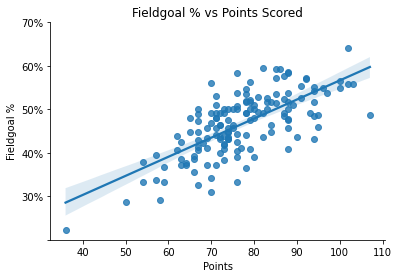

In [215]:
plt.title("Fieldgoal % vs Points Scored")
sns.regplot(data=data, x='pts', y='fg_pct')
plt.xticks(range(40, 120, 10))
plt.xlabel('Points')
plt.yticks([.20, .3, .4, .5, .6, .7], labels=['', '30%', '40%', '50%', '60%', '70%'])
plt.ylabel('Fieldgoal %')
sns.despine()
plt.show()

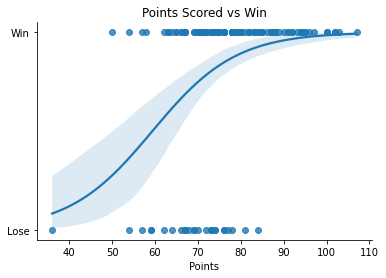

In [240]:
plt.title("Points Scored vs Win")
sns.regplot(data=data, x='pts', y='game_result', logistic=True)
plt.xticks(range(40, 120, 10))
plt.xlabel('Points')
plt.ylabel('')
plt.yticks([0, 1], labels=['Lose', 'Win'])
sns.despine()
plt.show()

## Rebounding

Rebounds are an interesting connection for a few reasons. First, a rebound can only happen on a missed shot. This can be a little misleading in that missed shots happen on a high volume of opponent shots too. If the opponent is attempting a lot of shots, it can also mean they are making many shots too. Rebounds will need to be explored more. Will also want to separate offensive and defensive rebounds to help bring the picture into focus. \

Lets take a closer look at rebounds. But first, lets calculate defensive rebounds by subtracting offensive rebounds from total rebounds.

In [137]:
data['drb'] = data['trb'] - data['orb']             # team defensive rebounds
data['opp_drb'] = data['opp_trb'] - data['opp_orb'] # opponent defensive rebounds
data['mov'] = data['pts'] - data['opp_pts']         # margin of victory


In [143]:
data['orb_pct'] = np.round(data['orb'] / (data['orb'] + data['opp_drb']), 3)
data['drb_pct'] = np.round(data['drb'] / (data['drb'] + data['opp_orb']), 3)

data['trb_pct'] = np.round(data['trb'] / (data['trb'] + data['opp_trb']), 3)

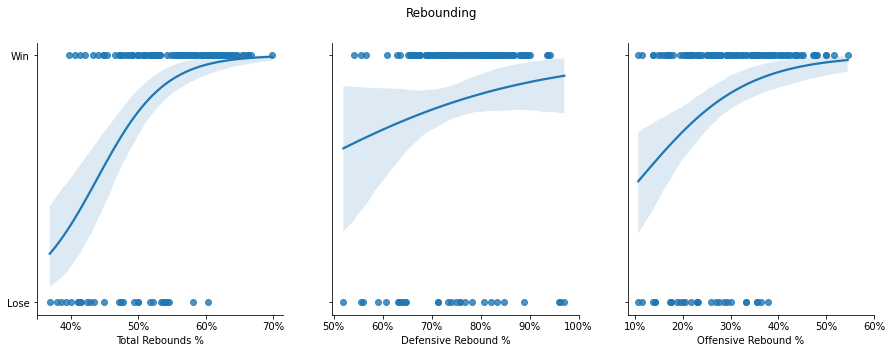

In [243]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Rebounding")

sns.regplot(data=data, x='trb_pct', y='game_result', logistic=True, ax=ax[0])
sns.regplot(data=data, x='drb_pct', y='game_result', logistic=True, ax=ax[1])
sns.regplot(data=data, x='orb_pct', y='game_result', logistic=True, ax=ax[2])
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_xlabel('Total Rebounds %')
ax[1].set_xlabel('Defensive Rebound %')
ax[2].set_xlabel('Offensive Rebound %')

ax[0].set_yticks([0, 1], minor=False)
ax[0].set_yticklabels(['Lose', 'Win'], minor=False)


ax[0].set_xticks([.35, .4, .5, .6, .7], minor=False)
ax[1].set_xticks([.5, .6, .7, .8, .9, 1], minor=False)
ax[2].set_xticks([.1, .2, .3, .4, .5, .6], minor=False)

ax[0].set_xticklabels(['', '40%', '50%', '60%', '70%'], minor=False)
ax[1].set_xticklabels(['50%', '60%', '70%', '80%', '90%', '100%'], minor=False)
ax[2].set_xticklabels(['10%', '20%', '30%', '40%', '50%', '60%'], minor=False)
sns.despine()
plt.show()

Fitting rebounds to a simple logistic regression model illustrates the clear relationship both offensive and defensive rebounds have to wins and losses. Offensive rebounds having the most noise makes sense in that they are less frequent. However, if a team can capture north of 40% of the offensive rebound opportunities, they will likely have a good chance of winning the game.

Next, lets look at how rebounding impacts points scored and shot attempts.

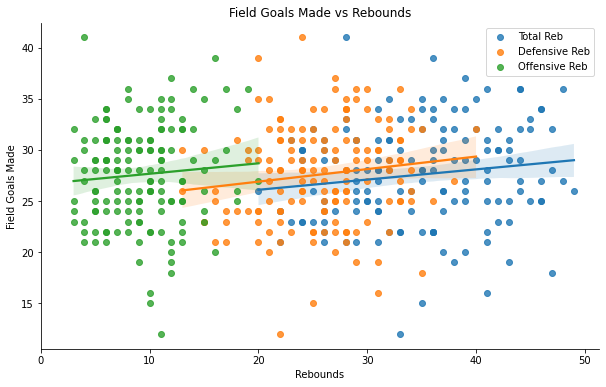

In [275]:
plt.figure(figsize=(10, 6))
plt.title('Field Goals Made vs Rebounds')
sns.regplot(data=data, x='trb', y='fg', label='Total Reb')
sns.regplot(data=data, x='drb', y='fg', label='Defensive Reb')
sns.regplot(data=data, x='orb', y='fg', label='Offensive Reb')
plt.xticks(range(0, 60, 10))
plt.xlabel('Rebounds')
plt.ylabel('Field Goals Made')
sns.despine()
plt.legend()
plt.show()

If we only look at total rebounds and field goals made, we don't see a clear relationship. The data is quite noisy. However, the picture comes into focus a little more if we compare rebounds to field goal attempts. 

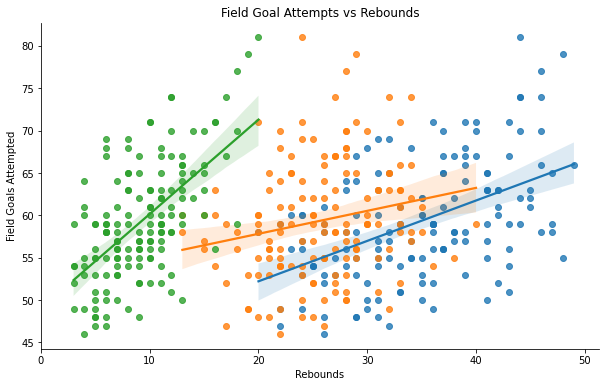

In [274]:
plt.figure(figsize=(10, 6))
plt.title('Field Goal Attempts vs Rebounds')
sns.regplot(data=data, x='trb', y='fga', label='Total Reb')
sns.regplot(data=data, x='drb', y='fga', label='Defensive Reb')
sns.regplot(data=data, x='orb', y='fga', label='Offensive Reb')
plt.xlabel('Rebounds')
plt.ylabel('Field Goals Attempted')
plt.xticks(range(0, 60, 10))
sns.despine()
plt.show()

Naturally field goals attempted will go up drastically as offensive rebounds increase as the shooting team will likely get another attempt quickly. Giving the opposing team less time to steal the ball or force a turnover. The slopes level out for defensive and total rebounds, but we still clearly have steeper slopes in their trend lines.

## Assisting

Assists have a strong correlation to points and ultimately winning. Intuitively, this makes sense. Great college teams tend to play good "team" ball. Where teamwork outweighs individual talent. Ball movement is also assumed to lead to an increase in open shot opportunities. Difficult to prove this without x/y coordinate data of the players, but it passes the sniff test.\
Steals are the inverse of assists. Steals often happen on poorly thrown passes (a potentially failed assist). So seeing the relationship between wins and assists/steals is likely solid.

Assists appeared to show a connection to points. Lets see if we can drill into that a bit more by normalizing the relationship between assists and field goals. We can do this by dividing the number of assists by the numbers of field goals made. We cannot compare the number of assists to field goal attempts because we do not know how many missed field goals would have been assisted had the shot gone in.

In [224]:
data['ast_pct'] = data['ast'] / data['fg']

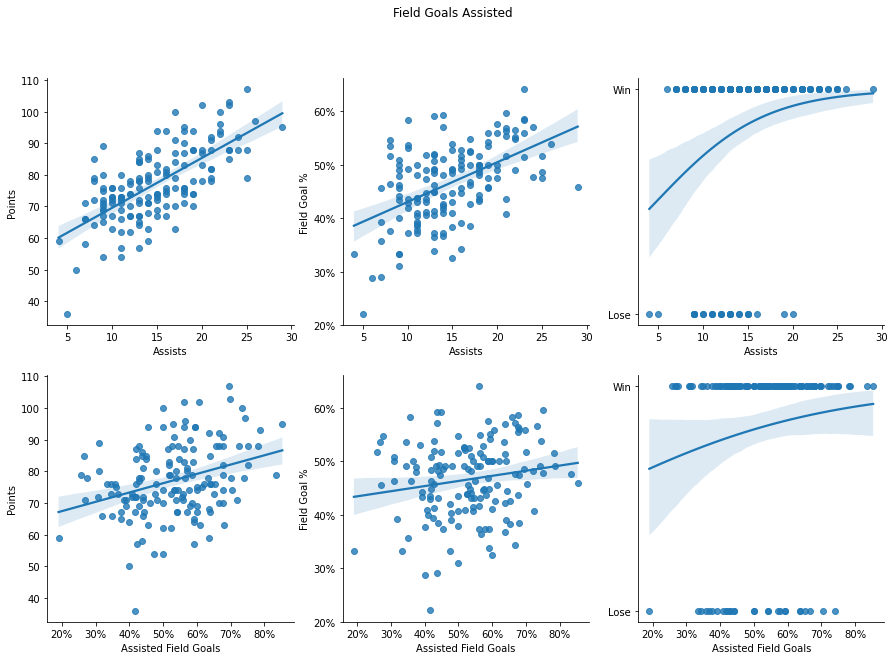

In [248]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

fig.suptitle("Field Goals Assisted")
sns.regplot(data=data, x='ast', y='pts', ax=ax[0, 0])
sns.regplot(data=data, x='ast', y='fg_pct', ax=ax[0, 1])
sns.regplot(data=data, x='ast', y='game_result', logistic=True, ax=ax[0, 2])

sns.regplot(data=data, x='ast_pct', y='pts', ax=ax[1, 0])
sns.regplot(data=data, x='ast_pct', y='fg_pct', ax=ax[1, 1])
sns.regplot(data=data, x='ast_pct', y='game_result', logistic=True, ax=ax[1, 2])

ax[0, 0].set_ylabel('Points')
ax[0, 1].set_ylabel('Field Goal %')
ax[0, 2].set_ylabel('')
ax[1, 0].set_ylabel('Points')
ax[1, 1].set_ylabel('Field Goal %')
ax[1, 2].set_ylabel('')

ax[0, 0].set_xlabel('Assists')
ax[0, 1].set_xlabel('Assists')
ax[0, 2].set_xlabel('Assists')
ax[1, 0].set_xlabel('Assisted Field Goals %')
ax[1, 1].set_xlabel('Assisted Field Goals %')
ax[1, 2].set_xlabel('Assisted Field Goals %')

ax[0, 1].set_yticks([.2, .3, .4, .5, .6])
ax[1, 1].set_yticks([.2, .3, .4, .5, .6])
ax[0, 1].set_yticklabels(['20%', '30%', '40%', '50%', '60%'])
ax[1, 1].set_yticklabels(['20%', '30%', '40%', '50%', '60%'])

ax[0, 2].set_yticks([0, 1])
ax[1, 2].set_yticks([0, 1])
ax[0, 2].set_yticklabels(["Lose", "Win"])
ax[1, 2].set_yticklabels(["Lose", "Win"])

ast_pct_ticks = [.2, .3, .4, .5, .6, .7, .8]
ax[1, 0].set_xticks(ast_pct_ticks, minor=False)
ax[1, 1].set_xticks(ast_pct_ticks, minor=False)
ax[1, 2].set_xticks(ast_pct_ticks, minor=False)

ast_pct_labels = ['20%', '30%', '40%', '50%', '60%', '70%', '80%']
ax[1, 0].set_xticklabels(ast_pct_labels, minor=False)
ax[1, 1].set_xticklabels(ast_pct_labels, minor=False)
ax[1, 2].set_xticklabels(ast_pct_labels, minor=False)

sns.despine()
plt.show()

It is important to not only look at the number of assists, but also the proportion of shots made that were assisted. If we only looked at the raw number of assists, well of course the more assists will naturally mean more points. More points means there were more opportunities for assists. Normalizing the data to be a proportion of shots made that were assisted will provide a more realistic picture for what is happening on the court. In each category, the numbers come back down to earth, but still show a clear correlation to points scored, field goal percentage, and wins.

Those familiar with basketball analytics are probably shouting at their screens: ["FOUR FACTORS!!"](https://www.basketball-reference.com/about/factors.html).. And they would be correct. Four factors are in fact great measures of overall team performance and really set the foundation for more advanced basketball analytics. Fourth factor is free throws, but I will not be going into it here.

# Set the table

To recap, we can see that field goal percentage is correlated to number of points scored. Number of points scored is correlated to wins. Nothing ground breaking here.

Controlling the boards with a higher rebound percentage will lead to extended or additional possessions, leading to more field goal attempts. More field goal attempts means more points. More points, higher chance of winning.

Teams that pass the ball more often will have an increase in field goal percentage. Increase in field goal percentage, you guessed it, increase in wins.

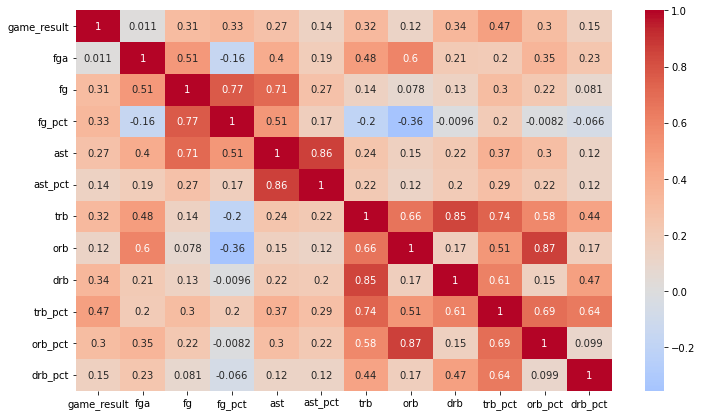

In [282]:
plt.figure(figsize=(12, 7))
feature_options = ['game_result', 'fga', 'fg', 'fg_pct', 'ast', 'ast_pct', 'trb', 'orb', 'drb', 'trb_pct', 'orb_pct', 'drb_pct']
sns.heatmap(data[feature_options].corr(), cmap='coolwarm', annot=True, center=0)
plt.show()

Now lets check our desired metrics against each other. We will want to select metrics that are not highly positively or negatively correlated, if possible.

Looking at field goal & field goal percentage, a strong connection exists (.77). We will not want to select both of these. Field goal percentage has the highest correlation to game result, so it will likely be the best option.

If we look at our rebounding numbers we can see there is a small negative correlation between field goal percentage and total rebounds & offensive rebounds, but almost no relationship to offensive and defensive rebound percentages. This is great! Offensive and defensive rebounding percentage are high correlated to total rebounds and total rebound percentage (of course). Total rebound percentage is the strongest correlation we have to game result. Rebounding is clearly an important data point and offensive and defensive rebound percentage could be the best option, given their independence from our other data points. Further testing will be necessary to decide if the raw number is best or if the percentage shows the most signal. But we know we are on to something. It is possible we see the best results from defensive rebounds and offensive rebound percentage.

Last, lets take a look at assists and their relationship to our various field goals and rebounds categories. As we learned earlier, assists are going to be correlated to field goal percentage. This will be unavoidable. But the percentage of assists is less correlated, so it will be a good option to explore more while testing models. Assist percentage, relative to raw assists is less correlated to both rebounds and rebound percentages, but we also see a significant drop off in correlation to game result. It will be worth testing both during the modeling stage.

Time to trim down our heat map.

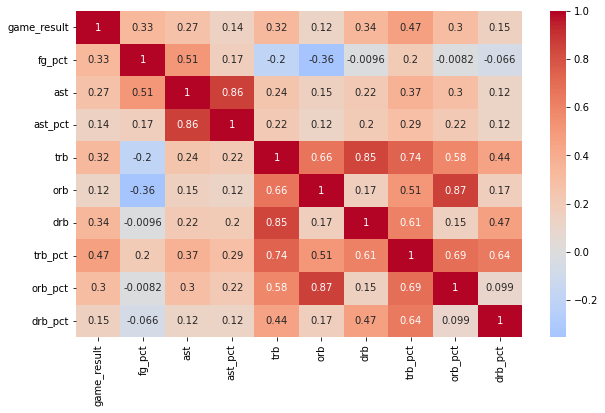

In [284]:
plt.figure(figsize=(10, 6))
sns.heatmap(data[['game_result', 'fg_pct', 'ast', 'ast_pct', 'trb', 'orb', 'drb', 'trb_pct', 'orb_pct', 'drb_pct']].corr(), cmap='coolwarm', annot=True, center=0)
plt.show()

## Predictive Features

It should be reasonably safe to say, field goal percentage, some variation of assists and rebounds provide some signal of what happened in the game leading to a win. However, we will not know the box score of the game until after the game occurs. This doesn't do us any good if our goal is to attempt to predict what might happen in future games. We will first want to check if the past is a good predictor of the future. There are numerous more complex ways to accomplish this with forecasting. ARIMA, SARIMA, RNN, VAR are some letters you can google if interested in learning more about forecasting methods.

I will be using some simple averages to test if we have reasonable predictors on our options for features.

In [286]:
feature_options = ['game_result', 'fga', 'fg', 'fg_pct', 'ast', 'ast_pct', 'trb', 'orb', 'drb', 'trb_pct', 'orb_pct', 'drb_pct']

In [322]:
data.sort_values(by=['school', 'date_game'], inplace=True)
data.reset_index(inplace=True, drop=True)

Make a group by to count the number of rows per school and assigning a game number. No school plays 2 games in 1 day, so we should be safe here. Function itself is not overly important as we could have saved the game number column from when we originally collected the data.

In [323]:
data['game_num'] = data.groupby(['school', 'date_game']).count().groupby(level=0).cumsum().reset_index()['conf']

Take a look to confirm our game_num column is ok

In [324]:
data[data['school'] == 'kansas']

,school,conf,date_game,game_location,opp_id,game_result,pts,opp_pts,fg,fga,...,opp_tov,opp_pf,drb,opp_drb,mov,orb_pct,drb_pct,trb_pct,ast_pct,game_num
38,kansas,big12,2021-11-09,neutral,Michigan State,1,87.0,74.0,31.0,64.0,...,16.0,18.0,22.0,27.0,13.0,0.206,0.733,0.453,0.419355,1
39,kansas,big12,2021-11-12,home,Tarleton State,1,88.0,62.0,34.0,58.0,...,8.0,17.0,28.0,15.0,26.0,0.400,0.800,0.633,0.676471,2
40,kansas,big12,2021-11-18,home,Stony Brook,1,88.0,59.0,35.0,70.0,...,13.0,14.0,28.0,25.0,29.0,0.324,0.848,0.571,0.542857,3
41,kansas,big12,2021-11-25,neutral,North Texas,1,71.0,59.0,26.0,51.0,...,10.0,19.0,28.0,23.0,12.0,0.179,0.824,0.532,0.538462,4
42,kansas,big12,2021-11-26,neutral,Dayton,0,73.0,74.0,30.0,60.0,...,17.0,15.0,13.0,20.0,-1.0,0.355,0.520,0.429,0.366667,5
43,kansas,big12,2021-11-28,neutral,Iona,1,96.0,83.0,39.0,71.0,...,18.0,18.0,20.0,15.0,13.0,0.516,0.741,0.621,0.564103,6
44,kansas,big12,2021-12-03,away,St. John's (NY),1,95.0,75.0,34.0,70.0,...,16.0,23.0,28.0,18.0,20.0,0.500,0.824,0.657,0.529412,7
45,kansas,big12,2021-12-07,home,UTEP,1,78.0,52.0,30.0,56.0,...,14.0,17.0,29.0,15.0,26.0,0.348,0.784,0.617,0.633333,8
46,kansas,big12,2021-12-11,home,Missouri,1,102.0,65.0,33.0,59.0,...,18.0,22.0,22.0,14.0,37.0,0.440,0.688,0.579,0.606061,9
47,kansas,big12,2021-12-18,home,Stephen F. Austin,1,80.0,72.0,26.0,54.0,...,19.0,21.0,16.0,22.0,8.0,0.290,0.727,0.472,0.538462,10


Make some baseline predictions for the feature options. Will only be looking at the raw numbers for our predictions as the percentages will be directly correlated and we cannot average the percentages together. Some games will have 80 FGA while others only 50. Shooting percentage per game does not have an equal weight game over game due to the field goal attempt discrepancy. We could calculate them, but the goal is to keep things simple here.

In [328]:
feature_options_reduced = ['fga', 'fg', 'ast', 'trb', 'orb', 'drb']

In [330]:
data[['school', 'game_num'] + feature_options_reduced].head()

,school,game_num,fga,fg,ast,trb,orb,drb
0,duke,1,60.0,31.0,8.0,31.0,6.0,25.0
1,duke,2,71.0,31.0,21.0,39.0,10.0,29.0
2,duke,3,50.0,25.0,16.0,30.0,6.0,24.0
3,duke,4,63.0,36.0,24.0,41.0,8.0,33.0
4,duke,5,79.0,36.0,19.0,48.0,19.0,29.0


Time for our baseline calculations. Baseline for this will be a combined simple average for all our features for all teams.

In [333]:
baseline_preds = np.round(data[feature_options_reduced].mean(), 1)
baseline_preds

fga    59.4
fg     27.6
ast    14.8
trb    35.0
orb     9.3
drb    25.7
dtype: float64

Just like that we have our baseline predictions. Now we will check to see if the first half of the year can predict the second half with a lower root mean squared error than our baseline prediction. RMSE is calculated by subtracting the baseline prediction (the mean) from the actual value, also known as the residual. The residual is squared and the mean of the squared error score. This is a our mean squared error (MSE). To put the error term back onto the same scale as our data we take the square root of the MSE. This is the root mean squared error or RMSE.

RMSE formula is listed below:

Lets take this step one at a time.
Ideally, our residuals will be normally distributed. The data set is very small, so slight deviations from a normal distribution will be expected.

fga


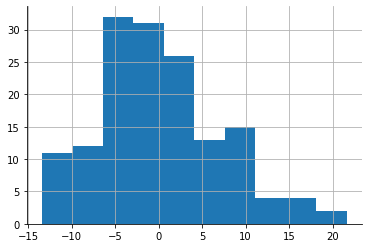

fg


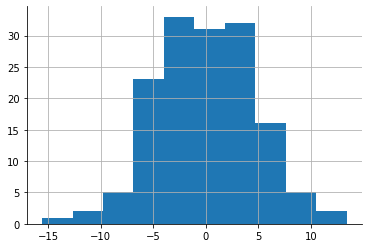

ast


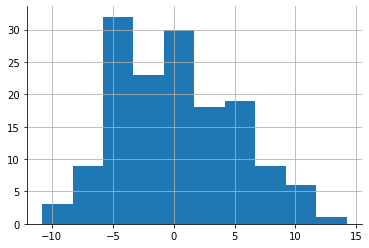

trb


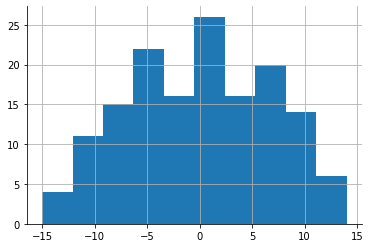

orb


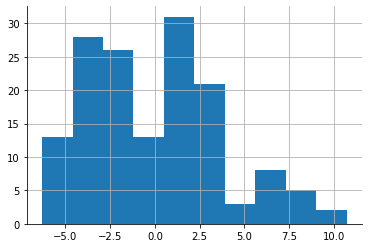

drb


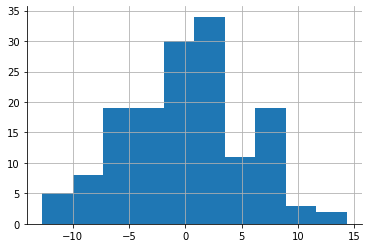

In [453]:
for feature in feature_options_reduced:
    print(feature)
    residuals = (data[feature] - baseline_preds[feature])
    residuals.hist()
    sns.despine()
    plt.show()

Our residuals mostly look normally distributed. Offensive rebounds is a little wonky. We might not get the best signal from it.

Mean squared error

In [356]:
np.mean(residuals**2)

6.926855948648951

RMSE

In [361]:
np.mean(residuals**2)**.5

6.926855948648951

In [369]:
def calc_rmse(y_pred, y_true):
    residuals = y_pred - y_true
    mse = np.mean(residuals ** 2)
    
    rmse = mse**.5

    return rmse


If our metric is predictive, we will have a lower RMSE in our prediction than in our baseline error

In [376]:
school_games = data.groupby(by=['school'])['game_num'].max()
school_games

school
duke              38
kansas            38
north-carolina    37
villanova         37
Name: game_num, dtype: int64

The 4 schools have played in 37 and 38 games. So we will check to see if the first 19 games can predict the last 18 or 19 more accurately than the baseline model.

In [378]:
preds = data[data['game_num'] <= 19].groupby(by=['school'])[feature_options_reduced].mean()
preds

,fga,fg,ast,trb,orb,drb
school,,,,,,
duke,61.368421,30.105263,18.000000,35.631579,9.263158,26.368421
kansas,61.105263,30.105263,16.368421,35.263158,10.947368,24.315789
north-carolina,61.157895,27.947368,14.578947,38.210526,9.631579,28.578947
villanova,57.263158,25.052632,12.736842,32.684211,9.157895,23.526316


Save the true values for the final 17-18 games per team. This is our ground truth. What we will be comparing our first half numbers against.

In [373]:
y_test = data[data['game_num'] > 19][['school', 'game_num'] + feature_options_reduced]
y_test

,school,game_num,fga,fg,ast,trb,orb,drb
19,duke,20,67.0,30.0,16.0,43.0,17.0,26.0
20,duke,21,66.0,26.0,11.0,49.0,15.0,34.0
21,duke,22,59.0,34.0,20.0,36.0,6.0,30.0
22,duke,23,52.0,22.0,14.0,36.0,11.0,25.0
23,duke,24,63.0,31.0,16.0,41.0,8.0,33.0
...,...,...,...,...,...,...,...,...
145,villanova,33,57.0,19.0,9.0,38.0,9.0,29.0
146,villanova,34,55.0,28.0,16.0,31.0,9.0,22.0
147,villanova,35,52.0,23.0,9.0,26.0,9.0,17.0
148,villanova,36,59.0,22.0,10.0,36.0,8.0,28.0


Here we will calculate the RMSE of the baseline predictions for each feature and save them so that we can compare them against the new prediction's estimate.

In [443]:
baseline_rmse = {}
for feature in feature_options_reduced:
    baseline_pred = np.full_like(y_test[feature], baseline_preds.loc[feature])

    baseline_rmse[feature] = calc_rmse(baseline_pred, y_test[feature])

{'fga': 6.3866837818800555,
 'fg': 4.965339323207892,
 'ast': 4.954877476871736,
 'trb': 6.81314310130933,
 'orb': 3.4079795076150803,
 'drb': 5.222948323427027}

Here we will calculate the new prediction by taking the average of each feature for the first half of the year and project that number into the second half of the year. It is a very rough prediction, but the goal is to either reduce the RMSE compared to the baseline or be VERY close to it. I don't expect this "model" to perform well, but it would be nice to know if there is any predictive power to early season numbers relative to late season numbers.

In [420]:
preds_2h = pd.DataFrame()

for feature in feature_options_reduced:
    pred_array = pd.Series(dtype=np.float64)
    for school in sorted(schools):
        _ = pd.Series(np.full_like(data[(data['school'] == school) & (data['game_num'] > 19)][feature], preds.loc[school, feature]))
        pred_array = pd.concat([pred_array, _])
    
    preds_2h = pd.concat([preds_2h, pred_array], axis=1, ignore_index=True)

preds_2h.columns = feature_options_reduced
preds_2h = preds_2h.add_prefix('pred_')
preds_2h.reset_index(inplace=True)
        

In [421]:
preds_2h

,index,pred_fga,pred_fg,pred_ast,pred_trb,pred_orb,pred_drb
0,0,61.368421,30.105263,18.000000,35.631579,9.263158,26.368421
1,1,61.368421,30.105263,18.000000,35.631579,9.263158,26.368421
2,2,61.368421,30.105263,18.000000,35.631579,9.263158,26.368421
3,3,61.368421,30.105263,18.000000,35.631579,9.263158,26.368421
4,4,61.368421,30.105263,18.000000,35.631579,9.263158,26.368421
...,...,...,...,...,...,...,...
69,13,57.263158,25.052632,12.736842,32.684211,9.157895,23.526316
70,14,57.263158,25.052632,12.736842,32.684211,9.157895,23.526316
71,15,57.263158,25.052632,12.736842,32.684211,9.157895,23.526316
72,16,57.263158,25.052632,12.736842,32.684211,9.157895,23.526316


Calculate the RMSE for the late season predictions...

In [428]:
pred_2h_rmse = {}
for feature in feature_options_reduced:
    pred_2h_rmse[feature] = calc_rmse(y_pred=preds_2h['pred_' + feature], y_true=y_test[feature])

In [532]:
compare = pd.DataFrame([baseline_rmse, pred_2h_rmse], index=['baseline', '2h_pred']).T
compare

,baseline,2h_pred
fga,6.386684,6.590283
fg,4.965339,4.805104
ast,4.954877,5.176754
trb,6.813143,7.264953
orb,3.407980,3.978571
drb,5.222948,5.013501


Give how small the sample size of our data set is, I'm mostly ok with these numbers. They're all very close. No major outliers.

In [617]:
data.shape

(150, 48)

Time to check the distribution of the residuals.

fga


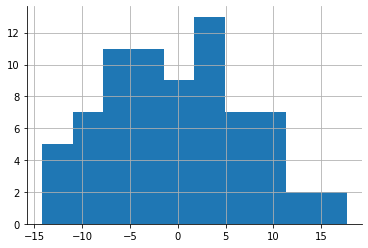

fg


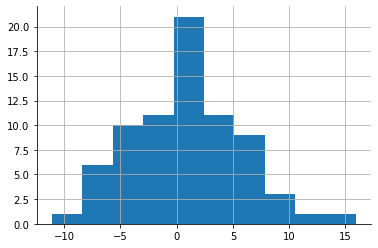

ast


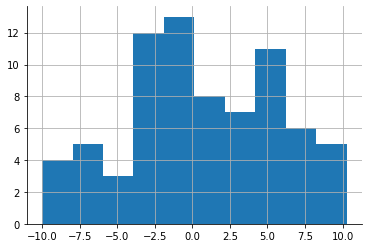

trb


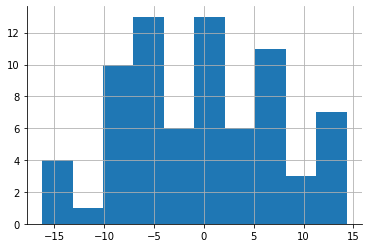

orb


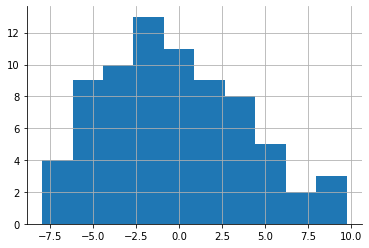

drb


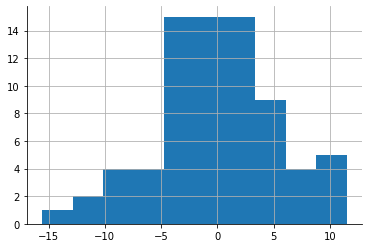

In [711]:
for feature in feature_options_reduced:
    print(feature)
    residuals = (data[feature] - preds_2h['pred_' + feature])
    residuals.hist()
    sns.despine()
    plt.show()

Assists and total rebounds are a little shaky, but they look close enough. Again, really small sample size, so don't want to get too bogged down on this. Distributions looked normal-ish.

Now, lets do an expanding/rolling mean for all the games. In other words, We will take the mean of all the past games to predict the next game's feature. For example, in game number 4 for field goal attempts, we will use the mean from games 1, 2, and 3 as the projection for field goal attempts in game 4. The prediction for game 5 will be the mean of games 1, 2, 3, and 4. We will do this for all n games for all our features. Given how fresh the data is, it is likely this will yield the best results of the 3 options that will be attempted.

In [619]:
rolled_data = pd.DataFrame()
for school in sorted(schools):
    rolled_school = data[data['school'] == school].shift(1)
    rolled_data = pd.concat([rolled_data, rolled_school], ignore_index=True)

rolled_data
    

,school,conf,date_game,game_location,opp_id,game_result,pts,opp_pts,fg,fga,...,opp_tov,opp_pf,drb,opp_drb,mov,orb_pct,drb_pct,trb_pct,ast_pct,game_num
0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,duke,acc,2021-11-09,neutral,Kentucky,1.0,79.0,71.0,31.0,60.0,...,13.0,20.0,25.0,22.0,8.0,0.214,0.610,0.449,0.258065,1.0
2,duke,acc,2021-11-12,home,Army,1.0,82.0,56.0,31.0,71.0,...,19.0,16.0,29.0,27.0,26.0,0.270,0.879,0.557,0.677419,2.0
3,duke,acc,2021-11-13,home,Campbell,1.0,67.0,56.0,25.0,50.0,...,7.0,14.0,24.0,19.0,11.0,0.240,0.706,0.508,0.640000,3.0
4,duke,acc,2021-11-16,home,Gardner-Webb,1.0,92.0,52.0,36.0,63.0,...,16.0,16.0,33.0,19.0,40.0,0.296,0.825,0.612,0.666667,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,villanova,bigeast,2022-03-11,neutral,UConn,1.0,63.0,60.0,23.0,54.0,...,7.0,12.0,22.0,25.0,3.0,0.107,0.629,0.397,0.608696,32.0
146,villanova,bigeast,2022-03-12,neutral,Creighton,1.0,54.0,48.0,19.0,57.0,...,11.0,13.0,29.0,25.0,6.0,0.265,0.707,0.507,0.473684,33.0
147,villanova,bigeast,2022-03-18,neutral,Delaware,1.0,80.0,60.0,28.0,55.0,...,10.0,15.0,22.0,16.0,20.0,0.360,0.815,0.596,0.571429,34.0
148,villanova,bigeast,2022-03-20,neutral,Ohio State,1.0,71.0,61.0,23.0,52.0,...,12.0,18.0,17.0,20.0,10.0,0.310,0.567,0.441,0.391304,35.0


In [620]:
pred_data = data[['school'] + feature_options_reduced].groupby(by=['school']).expanding().mean().reset_index(drop=True)
pred_data['school'] = data['school']
pred_data = pred_data.groupby('school').shift(1)
pred_data['school'] = data['school']
pred_data

,fga,fg,ast,trb,orb,drb,school
0,NaN,NaN,NaN,NaN,NaN,NaN,duke
1,60.000000,31.000000,8.000000,31.000000,6.000000,25.000000,duke
2,65.500000,31.000000,14.500000,35.000000,8.000000,27.000000,duke
3,60.333333,29.000000,15.000000,33.333333,7.333333,26.000000,duke
4,61.000000,30.750000,17.250000,35.250000,7.500000,27.750000,duke
...,...,...,...,...,...,...,...
145,56.281250,24.781250,12.156250,31.656250,8.718750,22.937500,villanova
146,56.303030,24.606061,12.060606,31.848485,8.727273,23.121212,villanova
147,56.264706,24.705882,12.176471,31.823529,8.735294,23.088235,villanova
148,56.142857,24.657143,12.085714,31.657143,8.742857,22.914286,villanova


Residual check time!

fga


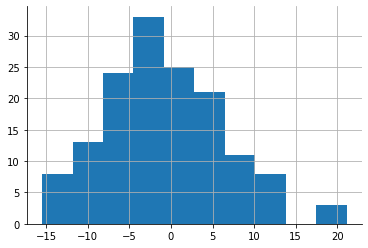

fg


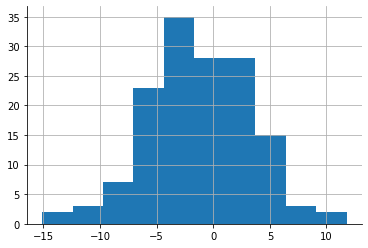

ast


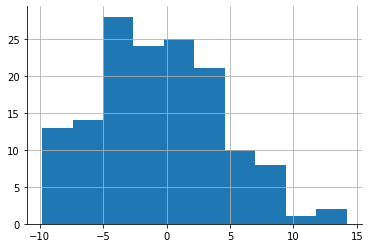

trb


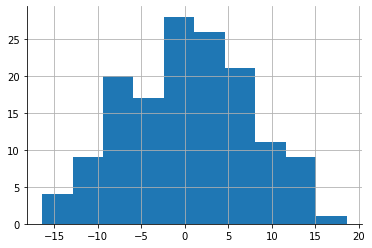

orb


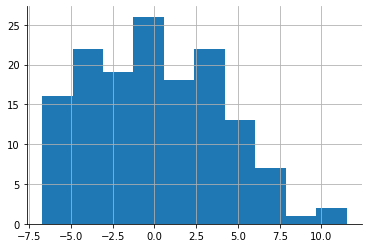

drb


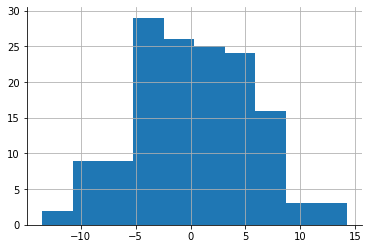

In [712]:
for feature in feature_options_reduced:
    print(feature)
    residuals = (data[feature] - pred_data[feature])
    residuals.hist()
    sns.despine()
    plt.show()

These residual distributions look the better than the previous two! We're headed in the right direction.

Moving on to calculating the RMSE.

In [621]:
pred_rolling_rmse = {}
for feature in feature_options_reduced:
    pred_rolling_rmse[feature] = calc_rmse(y_pred=pred_data[feature], y_true=y_test[feature])

Forecasted numbers have improved with the rolling average. It looks like they are predictive than the first half predicting the second half or a general average.

In [622]:
compare['rolling_pred'] = list(pd.Series(pred_rolling_rmse))
compare

,baseline,2h_pred,rolling_pred
fga,6.386684,6.590283,6.172481
fg,4.965339,4.805104,4.722172
ast,4.954877,5.176754,4.848330
trb,6.813143,7.264953,6.619059
orb,3.407980,3.978571,3.526303
drb,5.222948,5.013501,5.093390


Add game number back into the predictions.

In [624]:
pred_data['result'] = data['game_result']
pred_data['game_num'] = data['game_num']
pred_data.dropna(inplace=True)

In [625]:
pred_data

,fga,fg,ast,trb,orb,drb,school,result,game_num
1,60.000000,31.000000,8.000000,31.000000,6.000000,25.000000,duke,1,2
2,65.500000,31.000000,14.500000,35.000000,8.000000,27.000000,duke,1,3
3,60.333333,29.000000,15.000000,33.333333,7.333333,26.000000,duke,1,4
4,61.000000,30.750000,17.250000,35.250000,7.500000,27.750000,duke,1,5
5,64.600000,31.800000,17.600000,37.800000,9.800000,28.000000,duke,1,6
...,...,...,...,...,...,...,...,...,...
145,56.281250,24.781250,12.156250,31.656250,8.718750,22.937500,villanova,1,33
146,56.303030,24.606061,12.060606,31.848485,8.727273,23.121212,villanova,1,34
147,56.264706,24.705882,12.176471,31.823529,8.735294,23.088235,villanova,1,35
148,56.142857,24.657143,12.085714,31.657143,8.742857,22.914286,villanova,1,36


# Modeling

In [713]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Our data has a time component, so shuffling the data is not a viable option. These teams have a very high win percentage, so we need to have a training data set that includes both wins and losses. Preferably multiple. In a traditional handicapping environment, this data would be gathered over multiple years and many more than 4 teams. So we're painted into a bit of a corner here. But, we power on. 

The goal is to produce a "power ranking" or a relative weight of performance for our 4 remaining teams by using the features we have tracked to this point. In a nutshell, how has past performance in the assists, field goal attempts, field goal percentage, and rebounding, related to wins and losses. We will then compare the relative weights of our features for both teams in both match ups by using a logistic regression estimator. 

There are better estimators and certainly a wider range of features that can and should be tested before a model can compete with the prediction that is the point spread or moneyline odds set by the casino/sports book. The predictions that are soon to follow WILL NOT BE PROFITABLE AND SHOULD NOT BE WAGERED ON BASED ON THIS ANALYSIS. To restate, my intention with this mini-project is to illustrate the process a professional sports bettor will go through and what data tools are in their tool belt. To restate it for the record:

DO NOT BET ON THESE GAMES BASED ON THIS ANALYSIS.

In [653]:
training_data = pd.DataFrame()
testing_data = pd.DataFrame()
for school in sorted(schools):
    training_data = pd.concat([training_data, pred_data[(pred_data['game_num'] < 20) & (pred_data['school']==school)].copy()])  # data from the past
    testing_data = pd.concat([testing_data, pred_data[(pred_data['game_num'] >= 20) & (pred_data['school']==school)].copy()])   # data from the future
    

X_train, y_train = training_data[feature_options_reduced], training_data['result']
X_test, y_test = testing_data[feature_options_reduced], testing_data['result']

Data split in half for reasons stated above and scaled below. It is important to scale the data after splitting it so the testing data cannot influence the training data. We cannot use data from the "future" to make the predictions.

In [654]:
scaler = StandardScaler()

scaler.fit(X_train)                             # data from the past
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)        # data from the future

Simple logistic regression model instatiated.

In [657]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced')

In [714]:
y_test.value_counts(normalize=True)

1    0.837838
0    0.162162
Name: result, dtype: float64

Logistic regression will return a probability. This probability will then be used as a weight. Think of it this way. If Team A has a 60% chance to win against an average team and Team B has a 50% chance to win against an average team, then we can compare the relative weights and come up with an adjusted win percentage for both teams. Since our model features did not include opponent data, only team specific data, the prediction will be an estimate vs an "average" team. It should also be noted that our y test (wins) is significantly imbalanced (83.8% average win rate) and we do not have a large enough data set to perform bootstrapping techniques to return balance. But, we only have the data that we have, so lets make hay while the sun is shining.

We start by taking Team A's probability of victory against an average team (the number our model predicts) and dividing it by the sum of the probabilities of both teams.

In [660]:
pred_weights = lr.predict_proba(X_test_scaled)

Merge in school names against predictions.

In [716]:
school_weights = pd.concat([testing_data[['school']].reset_index(drop=True), pd.DataFrame(pred_weights[:,1])], axis=1, ignore_index=True)
school_weights

,0,1
0,duke,0.249982
1,duke,0.266097
2,duke,0.276444
3,duke,0.269278
4,duke,0.249882
...,...,...
69,villanova,0.626021
70,villanova,0.612352
71,villanova,0.604975
72,villanova,0.619846


Select the final prediction for all the schools

In [717]:
school_weights = school_weights.groupby(0).last().reset_index()

In [718]:
school_weights = school_weights.set_index(0)
school_weights

,1
0,
duke,0.357121
kansas,0.486650
north-carolina,0.323860
villanova,0.616097


Here we have our relative weights or "power rankings". Had we started with a larger and more robust data set, these numbers would likely be much higher. But we plan to compare them to each other, so we're making an apples-to-apples comparison.

## Team Matchup Analysis

Duke is playing UNC \
Villanova is playing Kansas

Duke's weight is .357121. UNC's weight is 0.323860. We estimate Duke's odds of winning by dividing Duke's weight by the sum of both weights.

Duke weight / (Duke weight + Villanova weight) \
.357121 / (.357121 + .323860)

The model predicts Duke will have a 52.4% chance to win against Villanova. (Again, small data, do not bet based on this number!!)

In [703]:
duke_prob = school_weights.loc['duke'] / (school_weights.loc['duke'] + school_weights.loc['north-carolina'])
duke_prob

1    0.524421
dtype: float64

We do the same for UNC and get an estimation of 47.6% or 1 - Duke's odds to win. Either way, we get to the same place.

In [706]:
unc_prob = school_weights.loc['north-carolina'] / (school_weights.loc['duke'] + school_weights.loc['north-carolina'])
unc_prob

1    0.475579
dtype: float64

Vil weight = 0.616097
Kansas weight = 0.486650

.616097 / (.616097 + .486650)

Villanova has an estimated win rate of 55.9%.

In [709]:
villanova_prob = school_weights.loc['villanova'] / (school_weights.loc['villanova'] + school_weights.loc['kansas'])
villanova_prob

1    0.558693
dtype: float64

1 - Villanova win rate = 44.1% = Kansas win probability.

In [710]:
kansas_prob = school_weights.loc['kansas'] / (school_weights.loc['villanova'] + school_weights.loc['kansas'])
kansas_prob

1    0.441307
dtype: float64

Lastly, we compare these numbers to the market price. As of Friday morning (the day before the game), the market currently has the following odds for all 4 teams:

Villanova +170 \
Kansas -175

& 

UNC +170 \
Duke -190

We can convert these to a percentage. I will write a blog on how to do this mathematically in the future, but for now, lets use [SBR's odds converter](https://www.sportsbookreview.com/betting-calculators/odds-converter/). We will be going from "American Odds" to "Implied Probability."



The market's implied probability for the 4 teams are as follows:

Villanova -- 37.0% \
Kansas -- 63.6%

UNC -- 37.0% \
Duke -- 65.5%

Note, the percentages do not add up to 100%. This discrepancy is how the casino makes a profit. It is our job to "overcome" this number. Our models have to not only be more predictive than the market price, but they have to be more predictive than the market price + the "juice" or house "vigorish."

Lets restate our predictions:

Villanova -- 55.8% \
Kansas -- 44.1%

UNC -- 47.6% \
Duke -- 52.4%

To revisit [estimated value](http://www.genewoodstock.com) from my previous blog post we know that we take the amount won multiplied by the probability of winning and subtract the amount lost by the probability of losing.

Lets start with Villanova. $100 risked will return $170 (plus the original wager). A wager of $175 on Kansas will return $100.

(170 * .559) - (100 * .441)

In [724]:
(170 * .559) - (100 * .441)

50.930000000000014

Villanova is positive expected value!! (DON'T BET BASED ON THIS ANALYSIS, ILLUSTRATION PURPOSES ONLY) \
Naturally, Kansas would be 1 - Villanova's expected value, with the vigorish reducing the estimated value further.

Lets do the same for UNC.

(170 * .476) - (100 * .524)

In [723]:
(170 * .476) - (100 * .524)

28.519999999999996

Again.... do not make a wager based on this number. Seriously. Don't do it!

Our overly simple model likes both underdogs! It likes Villanova almost twice as much as it likes UNC. The model would suggest there is more value backing Villanova than UNC, but both favorites are significantly overvalued. Professional bettors typically find themselves on the side of the underdog for many reasons that I will not get into in this piece.

It is unlikely that both underdogs will win, but a wager on both means only one has to win for us to walk away happy at the end of the day. A professional bettor does not judge success on one win or one loss, but rather on the entire body of work. Even if both underdogs lose, the bettor knows they took positive expected value positions on both games. Over a sample size of 100, 200, 1000 wagers the professional bettor will come out profitable, assuming their predictions are better calibrated than the market's prediction.

This is not intended to be betting advice. It is purely an exercise in the processes taken to estimate relative strengths between teams.